# Precipitation nowcast

It is based on https://github.com/pySTEPS/pysteps/blob/master/examples/my_first_nowcast.ipynb

In this example, we will use pysteps to compute and plot an extrapolation nowcast using the NSSL's Multi-Radar/Multi-Sensor System
([MRMS](https://www.nssl.noaa.gov/projects/mrms/)) rain rate product.

The MRMS precipitation product is available every 2 minutes, over the contiguous US. 
Each precipitation composite has 3500 x 7000 grid points, separated 1 km from each other.

## Init

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina' # High-resolution plot outputs for Retina laptops

## Getting the example data

Now that we have the environment ready, let's install the example data and configure the pysteps's default parameters by following [this tutorial](https://pysteps.readthedocs.io/en/latest/user_guide/example_data.html).

First, we will use the [pysteps.datasets.download_pysteps_data()](https://pysteps.readthedocs.io/en/latest/generated/pysteps.datasets.download_pysteps_data.html) function to download the data.


In [3]:
# Import the helper functions
# from pysteps.datasets import download_pysteps_data

# Download the pysteps data in the "pysteps_data"
# download_pysteps_data("pysteps_data")

## Create config file

In [4]:
# Import the helper functions
# from pysteps.datasets import create_default_pystepsrc

Next, we need to create a default configuration file that points to the downloaded data. 
By default, pysteps will place the configuration file in `$HOME/.pysteps` (unix and Mac OS X) or `$USERPROFILE/pysteps` (windows).
To quickly create a configuration file, we will use the [pysteps.datasets.create_default_pystepsrc()](https://pysteps.readthedocs.io/en/latest/generated/pysteps.datasets.create_default_pystepsrc.html#pysteps.datasets.create_default_pystepsrc) helper function.

In [5]:
# If the configuration file is placed in one of the default locations 
# (https://pysteps.readthedocs.io/en/latest/user_guide/set_pystepsrc.html#configuration-file-lookup) 
# it will be loaded automatically when pysteps is imported. 
# config_file_path = create_default_pystepsrc("pysteps_data")

Since pysteps was already initialized in this notebook, we need to load the new configuration file and update the default configuration.

In [6]:
# Import pysteps and load the new configuration file
import pysteps
# _ = pysteps.load_config_file(config_file_path, verbose=True)

Let's see what the default parameters look like (these are stored in the
[pystepsrc file](https://pysteps.readthedocs.io/en/latest/user_guide/set_pystepsrc.html)). We will be using them to load the MRMS data set.

In [7]:
# The default parameters are stored in pysteps.rcparams.
from pprint import pprint
pprint(pysteps.rcparams.data_sources['mrms'])

{'fn_ext': 'grib2',
 'fn_pattern': 'PrecipRate_00.00_%Y%m%d-%H%M%S',
 'importer': 'mrms_grib',
 'importer_kwargs': {},
 'path_fmt': '%Y/%m/%d',
 'root_path': '/Users/ilirium/OWM/weather/precipitation_forecasting_radar/pysteps_examples/pysteps_data/mrms',
 'timestep': 2}


This should have printed the following lines:

- `fn_ext`: 'grib2' -- The file extension
- `fn_pattern`: 'PrecipRate_00.00_%Y%m%d-%H%M%S' -- The file naming convention of the MRMS data.
- `importer`: 'mrms_grib' -- The name of the importer for the MRMS data.
- `importer_kwargs`: {} -- Extra options provided to the importer. None in this example.
- `path_fmt`: '%Y/%m/%d' -- The folder structure in which the files are stored. Here, year/month/day/filename.
- `root_path`: '/content/pysteps_data/mrms' -- The root path of the MRMS-data.
- `timestep`: 2 -- The temporal interval of the (radar) rainfall data

Note that the default `timestep` parameter is 2 minutes, which corresponds to the time interval at which the MRMS product is available.

## Load the MRMS example data

Now that we have installed the example data, let's import the example MRMS dataset using the [load_dataset()](https://pysteps.readthedocs.io/en/latest/generated/pysteps.datasets.load_dataset.html) helper function from the `pysteps.datasets` module.

We import 1 hour and 10 minutes of data, which corresponds to a sequence of 35 frames of 2-D precipitation composites.
Note that importing the data takes approximately 30 seconds.

In [8]:
from pysteps.datasets import load_dataset

# We'll import the time module to measure the time the importer needed
import time

start_time = time.monotonic()

# Import the data
precipitation, metadata, timestep = load_dataset('mrms',frames=35)  # precipitation in mm/h

end_time = time.monotonic()

print("Precipitation data imported")
print("Importing the data took ", (end_time - start_time), " seconds")

Precipitation data imported
Importing the data took  49.630983072  seconds


Let's have a look at the values returned by the `load_dataset()` function. 

- `precipitation`: A numpy array with (time, latitude, longitude) dimensions.
- `metadata`: A dictionary with additional information (pixel sizes, map projections, etc.).
- `timestep`: Time separation between each sample (in minutes)

In [9]:
# Let's inspect the shape of the imported data array
precipitation.shape

(35, 875, 1750)

Note that the shape of the precipitation is 4 times smaller than the raw MRMS data (3500 x 7000).
The `load_dataset()` function uses the default parameters from `importers` to read the data. By default, the MRMS importer upscales the data 4x. That is, from ~1km resolution to ~4km. It also uses single precision to reduce the memory requirements.
Thanks to the upscaling, the memory footprint of this example dataset is ~200Mb instead of the 3.1Gb of the raw (3500 x 7000) data. 

In [10]:
timestep # In minutes

2

In [11]:
pprint(metadata)

{'projection': {'ellps': 'IAU76', 'proj': 'latlon'},
 'threshold': 0.0125,
 'timestamps': array([datetime.datetime(2019, 6, 10, 0, 0),
       datetime.datetime(2019, 6, 10, 0, 2),
       datetime.datetime(2019, 6, 10, 0, 4),
       datetime.datetime(2019, 6, 10, 0, 6),
       datetime.datetime(2019, 6, 10, 0, 8),
       datetime.datetime(2019, 6, 10, 0, 10),
       datetime.datetime(2019, 6, 10, 0, 12),
       datetime.datetime(2019, 6, 10, 0, 14),
       datetime.datetime(2019, 6, 10, 0, 16),
       datetime.datetime(2019, 6, 10, 0, 18),
       datetime.datetime(2019, 6, 10, 0, 20),
       datetime.datetime(2019, 6, 10, 0, 22),
       datetime.datetime(2019, 6, 10, 0, 24),
       datetime.datetime(2019, 6, 10, 0, 26),
       datetime.datetime(2019, 6, 10, 0, 28),
       datetime.datetime(2019, 6, 10, 0, 30),
       datetime.datetime(2019, 6, 10, 0, 32),
       datetime.datetime(2019, 6, 10, 0, 34),
       datetime.datetime(2019, 6, 10, 0, 36),
       datetime.datetime(2019, 6, 10, 0, 

# Time to make a nowcast

So far, we have 1 hour and 10 minutes of precipitation images, separated 2 minutes from each other.
But, how do we use that data to run a precipitation forecast? 

A simple way is by extrapolating the precipitation field, assuming it will continue to move as observed in the recent past, and without changes in intensity. This is commonly known as *Lagrangian persistence*.

The first step to run our nowcast based on Lagrangian persistence, is the estimation of the motion field from a sequence of past precipitation observations.
We use the Lucas-Kanade (LK) optical flow method implemented in pysteps.
This method follows a local tracking approach that relies on the OpenCV package.
Local features are tracked in a sequence of two or more radar images.
The scheme includes a final interpolation step to produce a smooth field of motion vectors.
Other optical flow methods are also available in pysteps. 
Check the full list [here](https://pysteps.readthedocs.io/en/latest/pysteps_reference/motion.html).

Now let's use the first 5 precipitation images (10 min) to estimate the motion field of the radar pattern and the remaining 30 images (1h) to evaluate the quality of our forecast.

## Train and valid

In [12]:
# precipitation[0:5] -> Used to find motion (past data). Let's call it training precip.
train_precip = precipitation[0:5]

# precipitation[5:] -> Used to evaluate forecasts (future data, not available in "real" forecast situation)
# Let's call it observed precipitation because we will use it to compare our forecast with the actual observations.
observed_precip = precipitation[5:]

In [22]:
print(f'Shape for train is {train_precip.shape} and for valid is {observed_precip.shape}')

Shape for train is (5, 875, 1750) and for valid is (30, 875, 1750)


## Plot train precipitation map

Let's see what this 'training' precipitation event looks like using the [pysteps.visualization.plot_precip_field](https://pysteps.readthedocs.io/en/latest/generated/pysteps.visualization.precipfields.plot_precip_field.html) function.

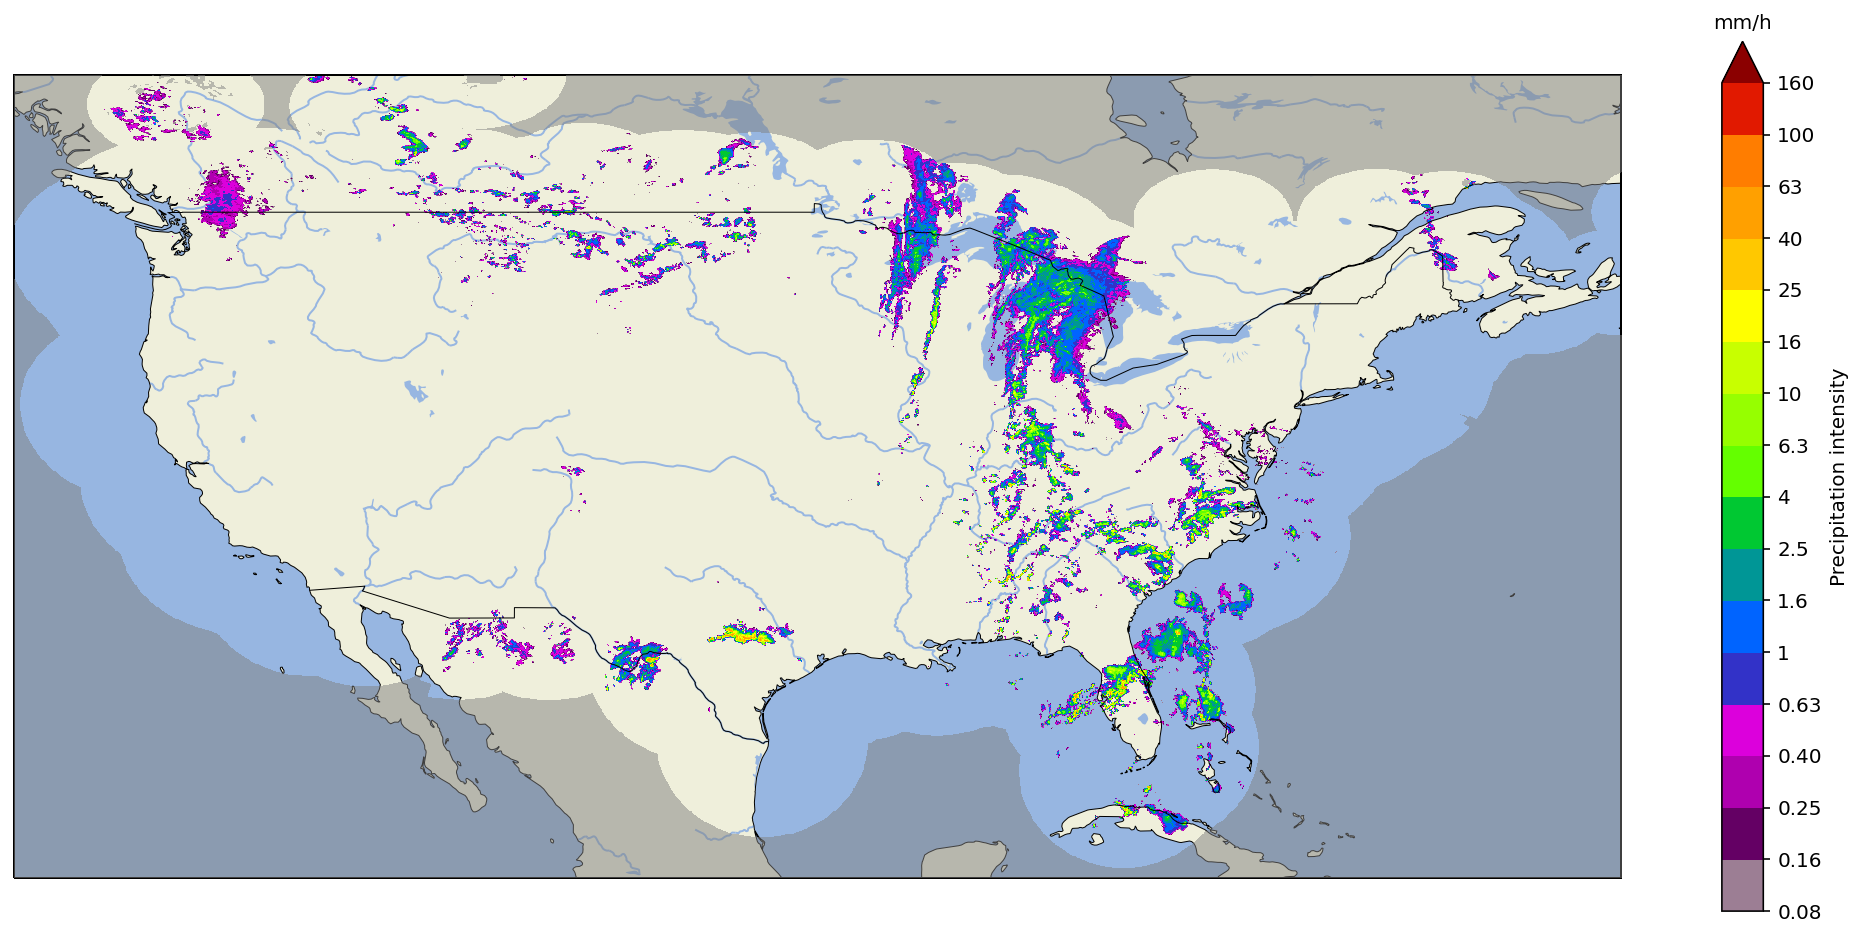

In [14]:
from matplotlib import pyplot as plt
from pysteps.visualization import plot_precip_field

# Set a figure size that looks nice ;)
plt.figure(figsize=(18, 10))

# Plot the last rainfall field in the "training" data.
# train_precip[-1] -> Last available composite for nowcasting.
plot_precip_field(train_precip[-1], geodata=metadata, axis="off", map="cartopy")
plt.show()  # (This line is actually not needed if you are using jupyter notebooks)

Did you note the **shaded grey** regions? Those are the regions were no valid observations where available to estimate the precipitation (e.g., due to ground clutter, no radar coverage, or radar beam blockage).
Those regions need to be handled with care when we run our nowcast.

## Data exploration (historgam)

Before we produce a forecast, let's explore the precipitation data. In particular, let's see how the distribution of the rain rate values looks.

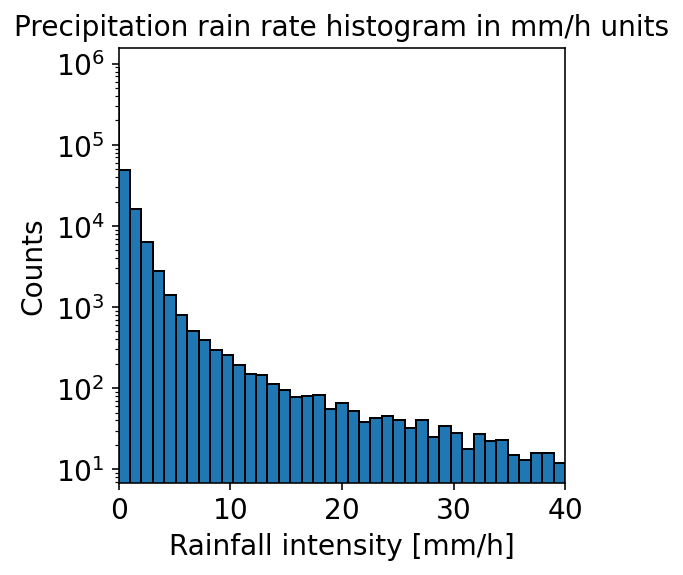

In [15]:
import numpy as np

# Let's define some plotting default parameters for the next plots
# Note: This is not strictly needed.
plt.rc('figure', figsize=(4,4))
plt.rc('font', size=14) # controls default text sizes
plt.rc('axes', titlesize=14) # fontsize of the axes title
plt.rc('axes', labelsize=14) # fontsize of the x and y labels
plt.rc('xtick', labelsize=14) # fontsize of the tick labels
plt.rc('ytick', labelsize=14) # fontsize of the tick labels

# Let's use the last available composite for nowcasting from the "training" data (train_precip[-1])
# Also, we will discard any invalid value.
valid_precip_values = train_precip[-1][~np.isnan(train_precip[-1])]

# Plot the histogram
bins= np.concatenate( ([-0.01,0.01], np.linspace(1,40,39)))
plt.hist(valid_precip_values,bins=bins,log=True, edgecolor='black')
plt.autoscale(tight=True, axis='x')
plt.xlabel("Rainfall intensity [mm/h]")
plt.ylabel("Counts")
plt.title('Precipitation rain rate histogram in mm/h units')
plt.show()

The histogram shows that rain rate values have a non-Gaussian and asymmetric distribution that is bounded at zero. Also, the probability of occurrence decays extremely fast with increasing rain rate values (note the logarithmic y-axis).


For better performance of the motion estimation algorithms, we can convert the rain rate values (in mm/h) to a more log-normal distribution  of rain rates by applying the following logarithmic transformation:

\begin{equation}
R\rightarrow
\begin{cases}
    10\log_{10}R, & \text{if } R\geq 0.1\text{mm h$^{-1}$} \\
    -15,          & \text{otherwise}
\end{cases}
\end{equation}

The transformed precipitation corresponds to logarithmic rain rates in units of dBR. The value of −15 dBR is equivalent to assigning a rain rate of approximately 0.03 mm h$^{−1}$ to the zeros. 

In [16]:
from pysteps.utils import transformation

# Log-transform the data to dBR. 
# The threshold of 0.1 mm/h sets the fill value to -15 dBR.
train_precip_dbr, metadata_dbr = transformation.dB_transform(train_precip, metadata, 
                                                             threshold=0.1, 
                                                             zerovalue=-15.0)

Let's inspect the resulting **transformed precipitation** distribution.

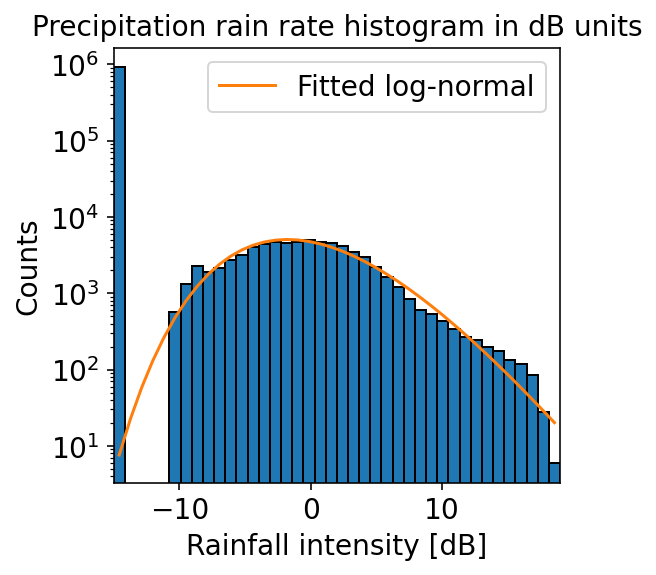

In [17]:
# Only use the valid data!
valid_precip_dbr = train_precip_dbr[-1][~np.isnan(train_precip_dbr[-1])]

plt.figure(figsize=(4, 4))

# Plot the histogram
counts, bins, _ = plt.hist(valid_precip_dbr, bins=40, log=True, edgecolor="black")
plt.autoscale(tight=True, axis="x")
plt.xlabel("Rainfall intensity [dB]")
plt.ylabel("Counts")
plt.title("Precipitation rain rate histogram in dB units")

# Let's add a lognormal distribution that fits that data to the plot.
import scipy

bin_center = (bins[1:] + bins[:-1]) * 0.5
bin_width = np.diff(bins)

# We will only use one composite to fit the function to speed up things.
# First, remove the no precip areas."
precip_to_fit = valid_precip_dbr[valid_precip_dbr > -15] 

fit_params = scipy.stats.lognorm.fit(precip_to_fit)

fitted_pdf = scipy.stats.lognorm.pdf(bin_center, *fit_params)

# Multiply pdf by the bin width and the total number of grid points: pdf -> total counts per bin.
fitted_pdf = fitted_pdf * bin_width * precip_to_fit.size

# Plot the log-normal fit
plt.plot(bin_center, fitted_pdf, label="Fitted log-normal")
plt.legend()
plt.show()

That looks more like a log-normal distribution. Note the large peak at -15dB. That peak corresponds to "zero" (below threshold) precipitation. The jump with no data in between -15 and -10 dB is caused by the precision of the data, which we had set to 1 decimal. Hence, the lowest precipitation intensities (above zero) are 0.1 mm/h (= -10 dB).